###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, heterogeneous models are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The Finite-Difference Method/fd_ac2d_heterogeneous.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Florian Wölfl and Lion Krischer ([@krischer](https://github.com/krischer)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/), notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

# 二维声学有限差分建模的简单吸收边界

地面地震采集系统的真实有限差分建模结果需要对二维声学有限代码进行进一步修改。
除了把模型的顶部设置为自由表面的边界条件外，我们还想去压制从其余界面产生的人造反射波。

例如 **吸收边界** 可以通过多种方法实现. 一个综合性的回顾可参见:

[Gao et al. 2015, Comparison of artificial absorbing boundaries for acoustic wave equation modelling](http://sourcedb.igg.cas.cn/cn/zjrck/201001/W020160519616038168413.pdf)

在实现吸收边界框架之前, 我们修改了优化后的二维声学有限差分代码的部分内容:

In [1]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Definition of initial modelling parameters
# ------------------------------------------
xmax = 2000.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax   # maximum spatial extension of the 1D model in z-direction (m)
dx   = 10.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)

tmax = 0.75    # maximum recording time of the seismogram (s)
dt   = 0.0010 # time step

vp0  = 3000.  # P-wave speed in medium (m/s)

# acquisition geometry
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc   # z-source position (m)

f0   = 100.0 # dominant frequency of the source (Hz)
t0   = 0.1   # source time shift (s)

isnap = 2  # snapshot interval (timesteps)

为了使代码模块化, 我们把波动方程的二阶偏导移到一个函数中 `update_d2px_d2pz`, 因此JIT装饰器的应用可以限制在这个函数中: 

In [3]:
@jit(nopython=True) # use JIT for C-performance
def update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
                
            d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
            d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
    return d2px, d2pz   

在有限差分建模代码 `FD_2D_acoustic_JIT`, 一个更加灵活的模型定义通过引入函数 `model`. 模块 `Initalize animation of pressure wavefield ` 时间循环前显示速度模型和初始压力波场。在时间循环中, 压力场被更新通过             

`image.set_data(p.T)`

`fig.canvas.draw()`

在每一个 `isnap` 时间步长:

In [4]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def FD_2D_acoustic_JIT(dt,dx,dz,f0):        
    
    # define model discretization
    # ---------------------------

    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)

    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)

    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)

    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))
    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.1 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2    
    
    # Define model
    # ------------    
    vp  = np.zeros((nx,nz))
    vp  = model(nx,nz,vp,dx,dz)
    vp2 = vp**2    
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p        
    
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(7,3.5))  # define figure size
    plt.tight_layout()
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot pressure wavefield movie
    ax1 = plt.subplot(121)
    image = plt.imshow(p.T, animated=True, cmap="RdBu", extent=extent, 
                          interpolation='nearest', vmin=-clip, vmax=clip)        
    plt.title('Pressure wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    
    # Plot Vp-model
    ax2 = plt.subplot(122)
    image1 = plt.imshow(vp.T/1000, cmap=plt.cm.viridis, interpolation='nearest', 
                        extent=extent)
    
    plt.title('Vp-model')
    plt.xlabel('x [m]')
    plt.setp(ax2.get_yticklabels(), visible=False) 
    
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(image1, cax=cax2)         
    plt.ion()    
    plt.show(block=False)
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        d2px, d2pz = update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2        
        
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # display pressure snapshots 
        if (it % isnap) == 0:
            image.set_data(p.T)
            fig.canvas.draw()       

## 无吸收边界框架的均匀块体模型

作为参考，我们首先建立了均匀块体模型, 定义在函数 `model` 中, 不包含吸收边界框架:

In [5]:
# Homogeneous model
def model(nx,nz,vp,dx,dz):
    
    vp += vp0 
    
    return vp

在定义完建模参数之后, 我们就可以运行改进的有限差分代码 ...

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


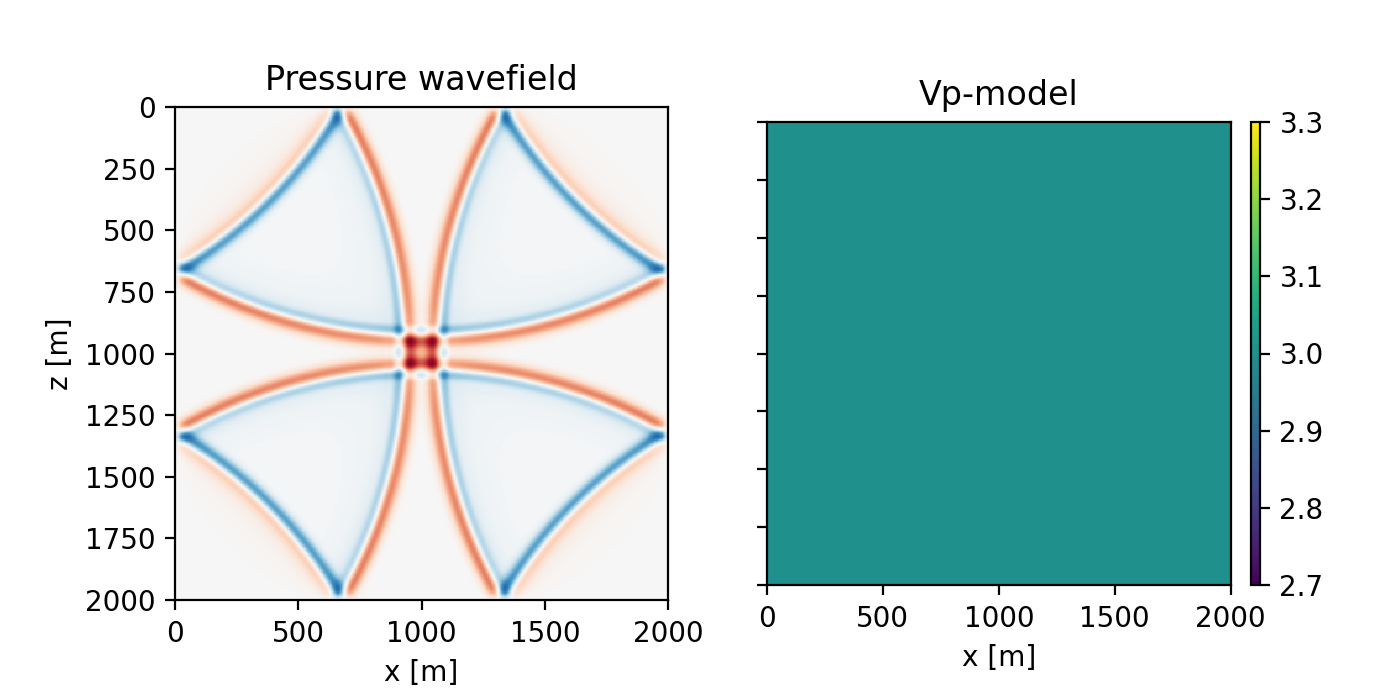

In [7]:
%matplotlib notebook
dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vp0)

FD_2D_acoustic_JIT(dt,dx,dz,f0)

注意波场动画中，强烈的人工边界反射

## 简单的吸收海绵边界

最简单，但不幸的是效率最低的吸收边界由 [Cerjan et al. (1985)](http://www.seismiccity.com/pdf/24_NonreflectingBoundary_1985.pdf) 提出. 它基于阻尼压力波场的简单思想 $p^n_{i,j}$ and $p^{n+1}_{i,j}$ 在吸收边界坐标系中:

\begin{equation}
f_{abs} = exp(-a^2(FW-i)^2), \nonumber
\end{equation}

这里 $FW$ 代表网格点边界框架的厚度, 然而，系数 $a$ 定义了框架内的阻尼变化. 在确定吸波函数时，应注意避免模型角处阻尼轮廓的重叠:

In [8]:
# Define simple absorbing boundary frame based on wavefield damping 
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):
   
    FW = 60     # thickness of absorbing frame (gridpoints)    
    a = 0.0053  # damping variation within the frame
    
    coeff = np.zeros(FW)
    
    # define coefficients
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

海绵边界的这种实现在模型之上设置了一个自由表面边界条件，而在其他边界处的切口波则被吸收:

<IPython.core.display.Javascript object>


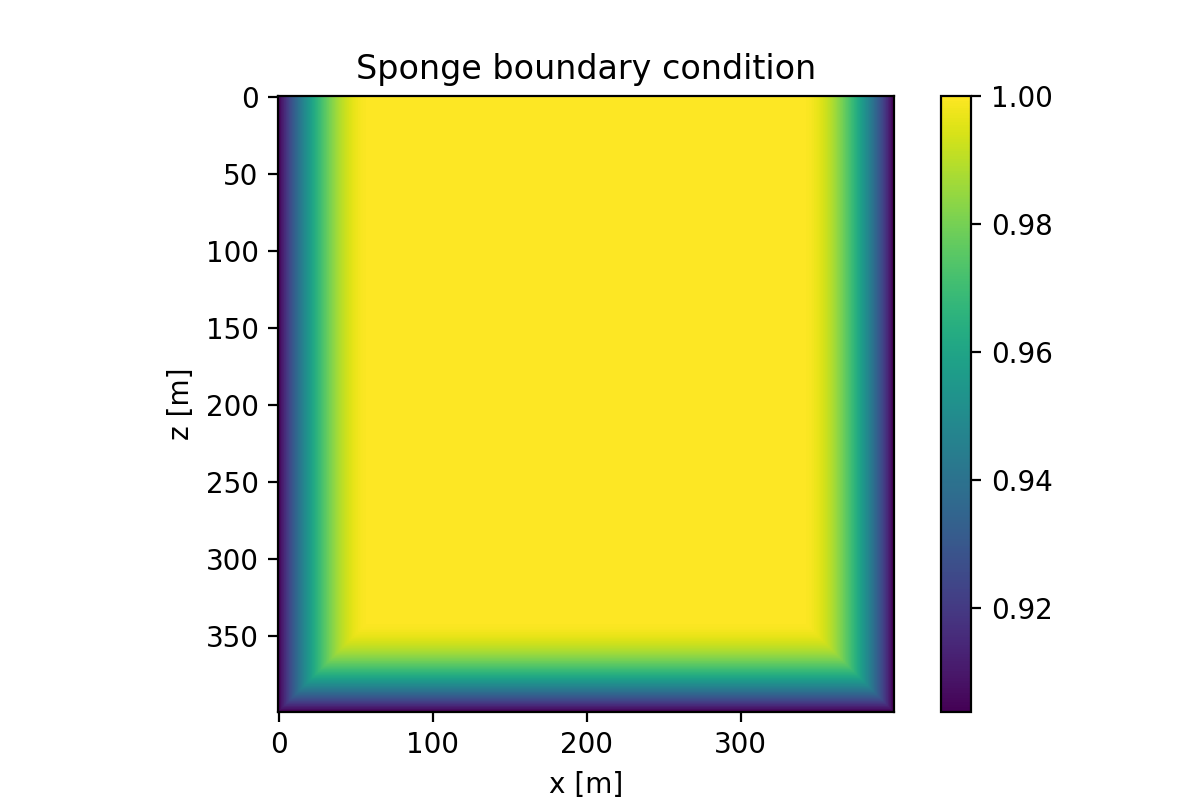

In [9]:
# Plot absorbing damping profile
# ------------------------------
fig = plt.figure(figsize=(6,4))  # define figure size
extent = [0.0,xmax,0.0,zmax]      # define model extension

# calculate absorbing boundary weighting coefficients
nx = 400
nz = 400
absorb_coeff = absorb(nx,nz)

plt.imshow(absorb_coeff.T)
plt.colorbar()
plt.title('Sponge boundary condition')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.show()

有限差分代码本身仅需要部分修改, 我们需要添加 `absorb` 函数来定义 to define边界框架中的阻尼量，并将阻尼函数应用于压力波场 `pnew` 和 `p`

In [10]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def FD_2D_acoustic_JIT_absorb(dt,dx,dz,f0):        
    
    # define model discretization
    # ---------------------------

    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)

    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)

    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)

    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))
    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.1 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2
    
    # Define absorbing boundary frame
    # ------------------------------- 
    absorb_coeff = absorb(nx,nz)
    
    # Define model
    # ------------    
    vp  = np.zeros((nx,nz))
    vp  = model(nx,nz,vp,dx,dz)
    vp2 = vp**2    
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p    
    
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(7,3.5))  # define figure size
    plt.tight_layout()
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot pressure wavefield movie
    ax1 = plt.subplot(121)
    image = plt.imshow(p.T, animated=True, cmap="RdBu", extent=extent, 
                          interpolation='nearest', vmin=-clip, vmax=clip)        
    plt.title('Pressure wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    
    # Plot Vp-model
    ax2 = plt.subplot(122)
    image1 = plt.imshow(vp.T/1000, cmap=plt.cm.viridis, interpolation='nearest', 
                        extent=extent)
    
    plt.title('Vp-model')
    plt.xlabel('x [m]')    
    plt.setp(ax2.get_yticklabels(), visible=False) 
    
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="2%", pad=0.1)
    fig.colorbar(image1, cax=cax2)         
    plt.ion()    
    plt.show(block=False)
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        d2px, d2pz = update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
        
        # Apply absorbing boundary frame
        p *= absorb_coeff
        pnew *= absorb_coeff
        
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # display pressure snapshots 
        if (it % isnap) == 0:
            image.set_data(p.T)
            fig.canvas.draw()       

让我们评估海绵边界对人工边界反射的影响:

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


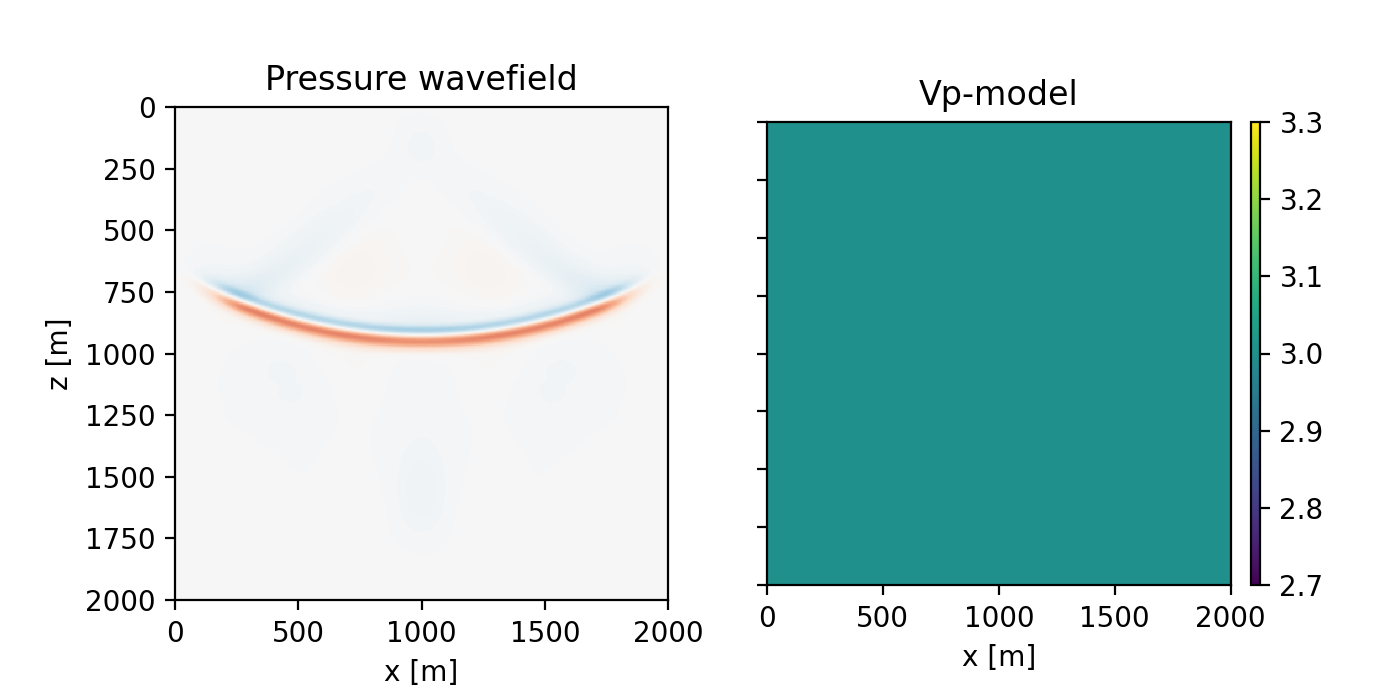

In [12]:
%matplotlib notebook
dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vp0)

FD_2D_acoustic_JIT_absorb(dt,dx,dz,f0)

如你所见，边界反射明显被抑制了。然而，仍然可以看到一些伪反射. 抑制这些反射需要更复杂的吸收边界，例如 **Perfectly Matched Layers (PMLs)**.

## 我们学习到:

- 如何通过简单的吸收海绵边界来抑制边界反射，实现真实的半空间模型